In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

In [20]:
df = pd.read_csv("Tweets.csv")
df[["airline_sentiment","text"]].head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


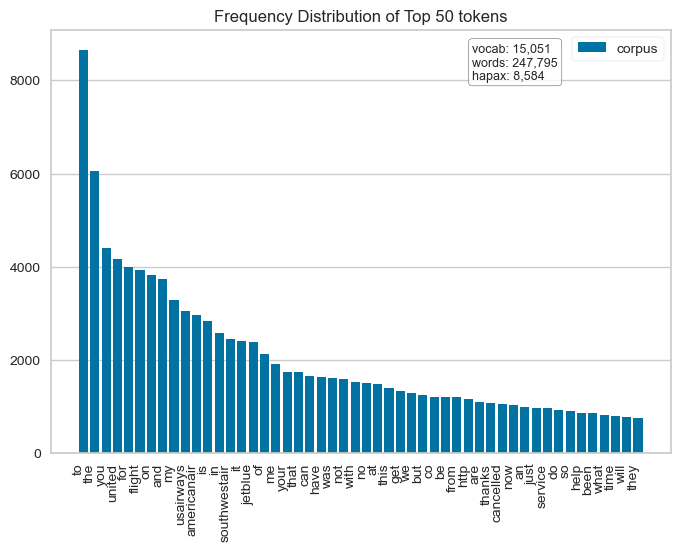

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [21]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [22]:
text = df["text"]
labels = df["airline_sentiment"]

print(text.shape, labels.shape)

(14640,) (14640,)


In [23]:
# remove digits, @-mentions, links, stopwords

text = text.str.lower()
text = text.apply(lambda elem: re.sub(r"@[a-zA-Z0-9-]+", "", elem))
text = text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
text = text.apply(lambda x : nltk.word_tokenize(x))
text = text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["rt"])]))

text.shape

(14640,)

In [24]:
import pickle
with open("text.pkl", "wb") as f:
  pickle.dump(text, f)
with open("labels.pkl", "wb") as f:
  pickle.dump(labels, f)

In [25]:
# with open("text.pkl", "rb") as f:
#   text = pickle.load(f)
# with open("labels.pkl", "rb") as f:
#   labels = pickle.load(f)

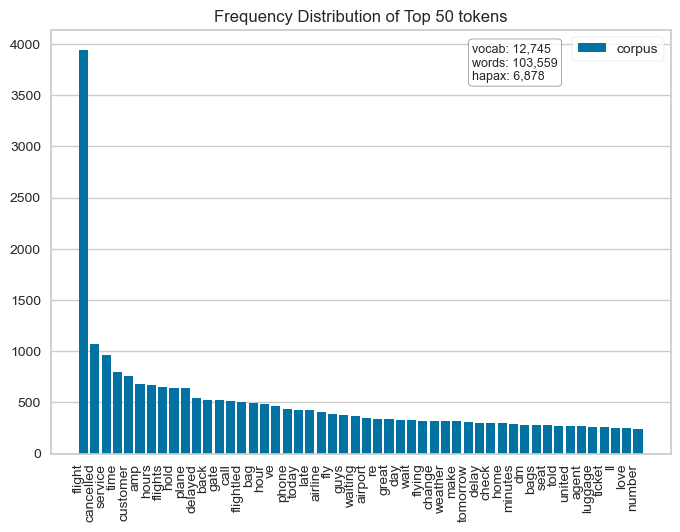

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [26]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(text)
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [27]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
lengths = []

X = text
for i in range(len(text)):
  X[i] = tokenizer.tokenize(X[i])
  X[i] = tokenizer.convert_tokens_to_ids(X[i])

for i in range(len(X)):
  lengths.append(len(X[i]))

In [29]:
lengths = np.array(lengths)
X = np.array(X)

print(np.sum((lengths < 64) & (labels == "positive")), np.mean((lengths < 64) & (labels == "positive")))
print(np.sum((lengths < 64) & (labels == "neutral")), np.mean((lengths < 64) & (labels == "neutral")))
print(np.sum((lengths < 64) & (labels == "negative")), np.mean((lengths < 64) & (labels == "negative")))

2363 0.16140710382513662
3099 0.21168032786885246
9178 0.6269125683060109


In [30]:
X_positive = X[(lengths < 64) & (labels == "positive")].tolist()
X_neutral = X[(lengths < 64) & (labels == "neutral")].tolist()
X_negative = X[(lengths < 64) & (labels == "negative")].tolist()
X = X_positive[:2000] + X_negative[:2000]

y_positive = labels[(lengths < 64) & (labels == "positive")].tolist()
y_neutral = labels[(lengths < 64) & (labels == "neutral")].tolist()
y_negative = labels[(lengths < 64) & (labels == "negative")].tolist()
y = y_positive[:2000] + y_negative[:2000]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), train_size=500, shuffle=True)

X_test = X_test[:50]
y_test = y_test[:50]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [32]:
import torch

model.config.max_position_embeddings = 64
max_length = model.config.max_position_embeddings

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [33]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.3323, -0.2663,  0.1031,  ..., -0.7566,  0.3848,  0.1211],
         [-0.1514, -0.0827,  0.8188,  ..., -0.5397,  0.2893,  0.1591],
         [-0.4809, -0.2428,  0.7066,  ..., -0.5248,  0.3225,  0.1173],
         ...,
         [-0.2328, -0.4173,  0.1504,  ..., -0.7372,  0.3948, -0.1057],
         [-0.2298, -0.4225,  0.1438,  ..., -0.7196,  0.4245, -0.0945],
         [-0.2145, -0.4120,  0.1284,  ..., -0.7197,  0.4312, -0.1000]],

        [[-0.1117, -0.2732,  0.1138,  ..., -1.0426,  0.4047,  0.0577],
         [ 0.3244, -0.0245,  0.3934,  ..., -0.5639,  0.1313, -0.3406],
         [ 0.3786, -0.1324,  0.2623,  ..., -0.6588,  0.1516, -0.1528],
         ...,
         [-0.2044, -0.4668,  0.2014,  ..., -1.0200,  0.3517, -0.0904],
         [-0.2066, -0.4620,  0.1873,  ..., -1.0061,  0.3560, -0.0924],
         [-0.2039, -0.4283,  0.1634,  ..., -1.0143,  0.3325, -0.1105]],

        [[-0.0911, -0.2561,  0.1420,  ..., -0.3650, -

In [34]:
bert_train_output = bert_train_output[1].detach().numpy().copy()
bert_train_output = bert_train_output.reshape(X_train.shape[0], 768)

In [35]:
bert_test_output = model(X_test_padded)
print(bert_test_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0034,  0.0015,  0.3991,  ..., -0.5459,  0.5640,  0.1055],
         [ 0.0082,  0.1214,  0.6608,  ..., -0.6235,  0.2829, -0.2303],
         [-0.1452,  0.0263,  0.6750,  ..., -0.6157,  0.2162, -0.1838],
         ...,
         [ 0.0025, -0.0718,  0.0883,  ..., -0.5501,  0.7020, -0.0231],
         [-0.0055, -0.0614,  0.0802,  ..., -0.5440,  0.7230, -0.0147],
         [ 0.0097, -0.0241,  0.0604,  ..., -0.5550,  0.7169, -0.0235]],

        [[-0.2832, -0.1557, -0.0569,  ..., -0.7215,  0.7339, -0.0514],
         [-0.2382,  0.2722,  0.5685,  ..., -0.4548,  0.5916,  0.2188],
         [-0.0746,  0.0288,  0.3906,  ..., -0.4144,  0.4944,  0.1900],
         ...,
         [-0.2854, -0.2220,  0.0258,  ..., -0.7179,  0.6091, -0.2794],
         [-0.2954, -0.2016,  0.0202,  ..., -0.7292,  0.6052, -0.2790],
         [-0.2910, -0.1766, -0.0017,  ..., -0.7358,  0.5794, -0.3060]],

        [[-0.0850, -0.1181,  0.4033,  ..., -0.4269,  

In [36]:
bert_test_output = bert_test_output[1].detach().numpy().copy()
bert_test_output = bert_test_output.reshape(X_test.shape[0], 768)

In [37]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [38]:
clf = neural_network.MLPClassifier()
clf.fit(bert_train_output, le.transform(y_train))

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


MLPClassifier()

In [39]:
print("Train accuracy:", np.mean(clf.predict(bert_train_output) == le.transform(y_train)))
print("Test accuracy:", np.mean(clf.predict(bert_test_output) == le.transform(y_test)))

Train accuracy: 0.872
Test accuracy: 0.58


In [40]:
print(np.unique(y_test))

['negative' 'positive']


In [41]:
np.mean(y_test=="neutral")

0.0

In [42]:
shap.initjs()

In [43]:
to_explain = np.array(X_test_padded)[:20]
to_explain.shape

(20, 64)

In [44]:
def prediction_model(X):
  bert_output = model(torch.from_numpy(np.array(X)).to(torch.int64))
  sequence_output = bert_output[1].detach().numpy()
  return clf.predict(sequence_output.reshape(X.shape[0], 768))

In [45]:
permutation_values = []
permutation_explainer = shap.explainers.Permutation(prediction_model, to_explain)
for i in range(20):
  permutation_values.append(permutation_explainer(np.array([to_explain[i]])))

Permutation explainer: 2it [26:52, 1612.36s/it]             
Permutation explainer: 2it [56:31, 3391.12s/it]             
Permutation explainer: 2it [1:00:39, 3639.20s/it]           
Permutation explainer: 2it [1:36:20, 5780.75s/it]           
Permutation explainer: 2it [1:04:36, 3876.69s/it]           
Permutation explainer: 2it [43:24, 2604.79s/it]             
Permutation explainer: 2it [55:30, 3330.31s/it]             
Permutation explainer: 2it [41:37, 2497.42s/it]             
Permutation explainer: 2it [37:27, 2247.11s/it]             
Permutation explainer: 2it [1:13:44, 4424.63s/it]           
Permutation explainer: 2it [58:30, 3510.94s/it]             
Permutation explainer: 2it [40:14, 2414.22s/it]             
Permutation explainer: 2it [59:59, 3599.53s/it]             
Permutation explainer: 2it [41:39, 2499.87s/it]             
Permutation explainer: 2it [38:25, 2305.88s/it]             
Permutation explainer: 2it [35:19, 2119.12s/it]             
Permutation explainer: 2

In [136]:
perm_vals = {"values": [], "base_values": [], "data": []}
for pv in permutation_values:
    perm_vals["values"].append(pv.values[0])
    perm_vals["base_values"].append(pv.base_values[0])
    perm_vals["data"].append(pv.data[0])

Sentence: wow unbelievable treat customers puerto rico airport ! [UNK] ; Prediction: [0] ; True value: positive


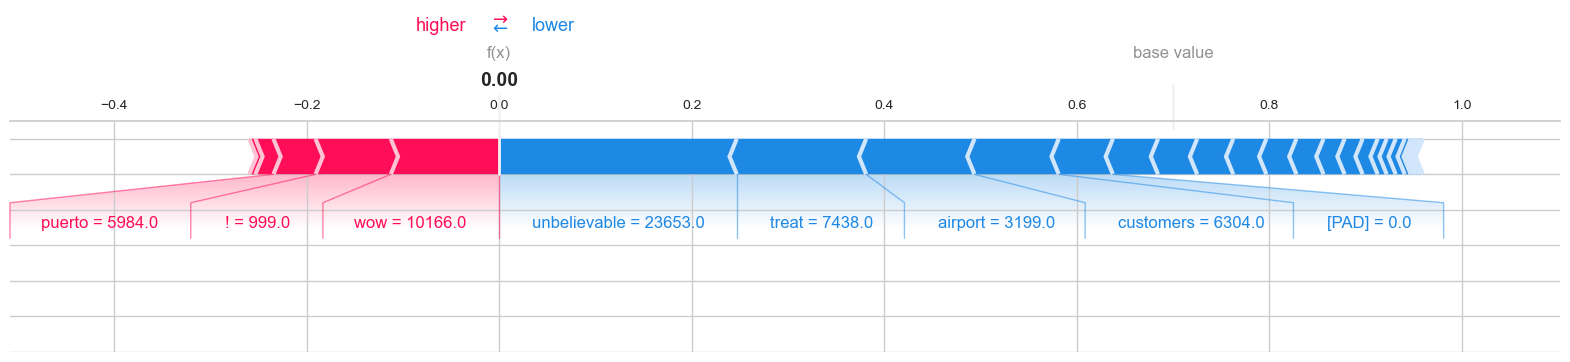

Sentence: katie , gate c ##47 , denver international , fantastic customer service helping 2 flyers ; th ##x amazing staff ! ; Prediction: [1] ; True value: positive


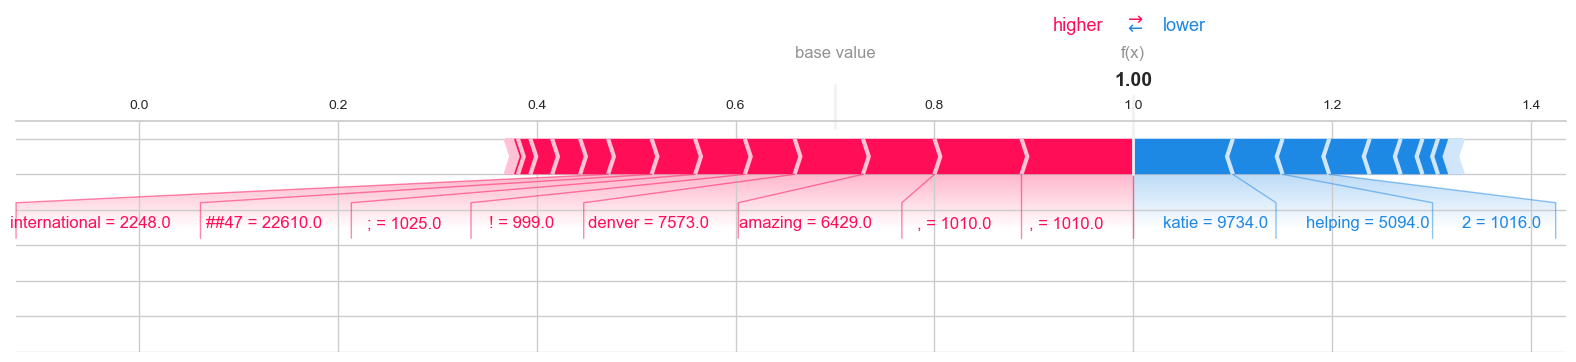

Sentence: flight ( told ) 4 : 50 today . . , checked email 4 ; 50 tomorrow . unacceptable . ; Prediction: [1] ; True value: negative


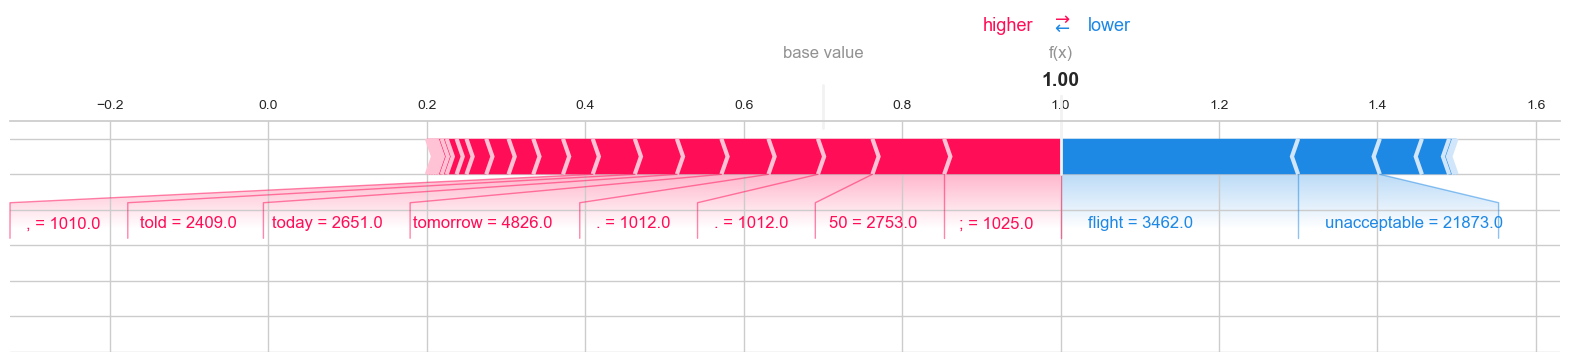

Sentence: delayed cm ##h or ##d . ran gate 1 b ##4 connection - door closed . ignored 1st agent , 2nd super rude . # thanks ##uni ##ted ; Prediction: [0] ; True value: negative


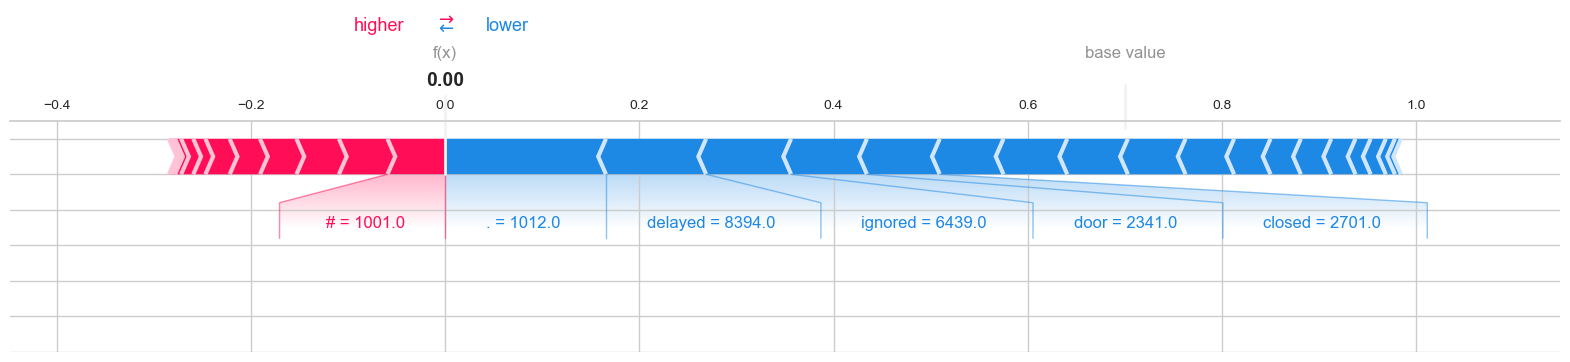

Sentence: failed un ##con ##tro ##lla ##bly today ' s repair . ' m liv ##id absolute disregard operations . ; Prediction: [0] ; True value: negative


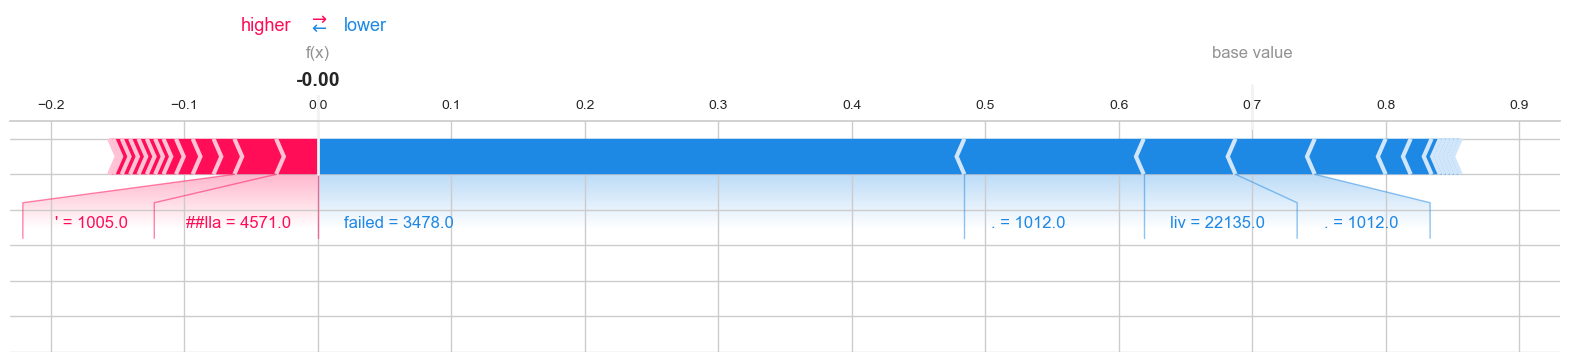

Sentence: whoa . ' s wanted hear ! early flight coming . reply . ; Prediction: [0] ; True value: positive


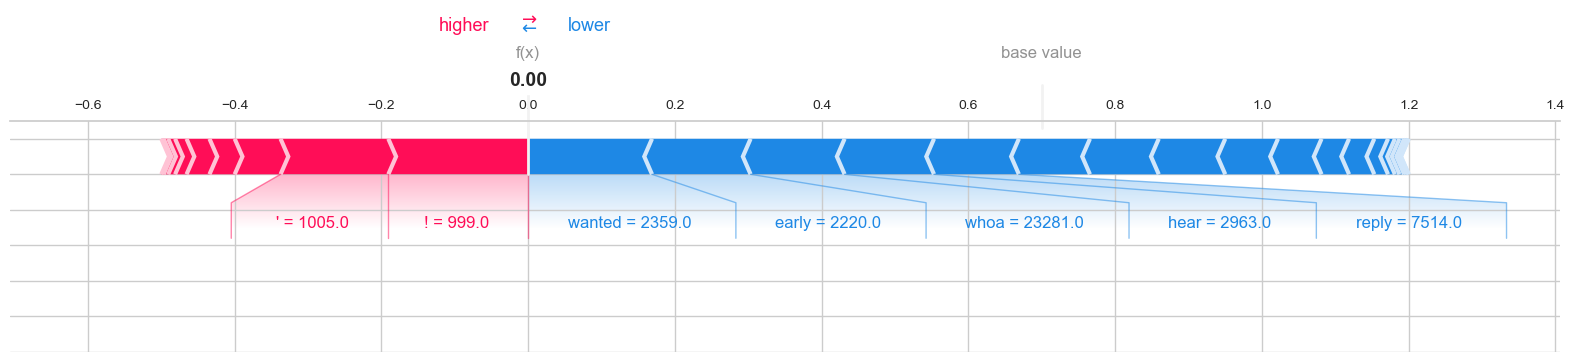

Sentence: failed week ia ##h . int ##l trip delta . small ua ##l flight lax booked , ' s ! ; Prediction: [0] ; True value: negative


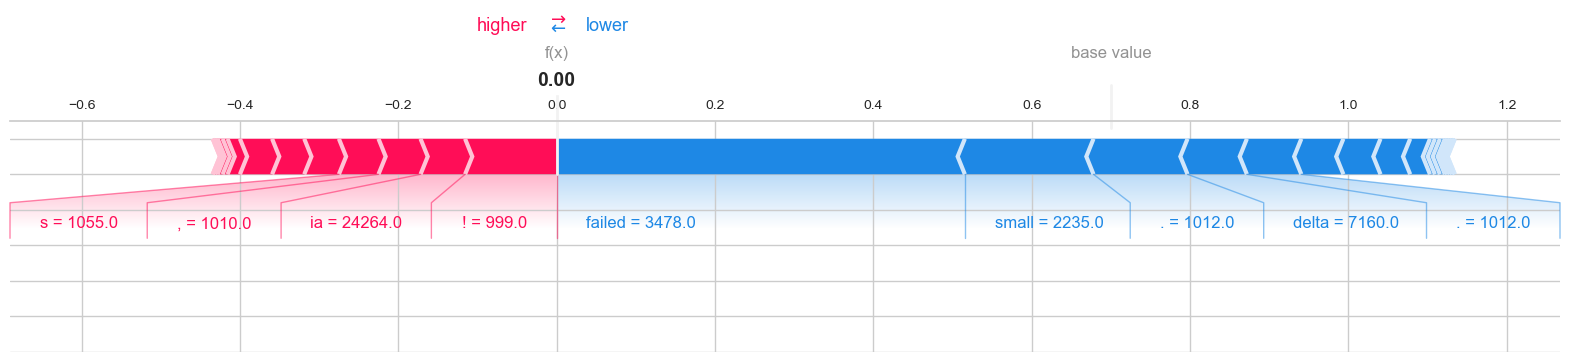

Sentence: 232 ##4 orlando dc ##a ! awesome flight attendant robert ! ; Prediction: [1] ; True value: positive


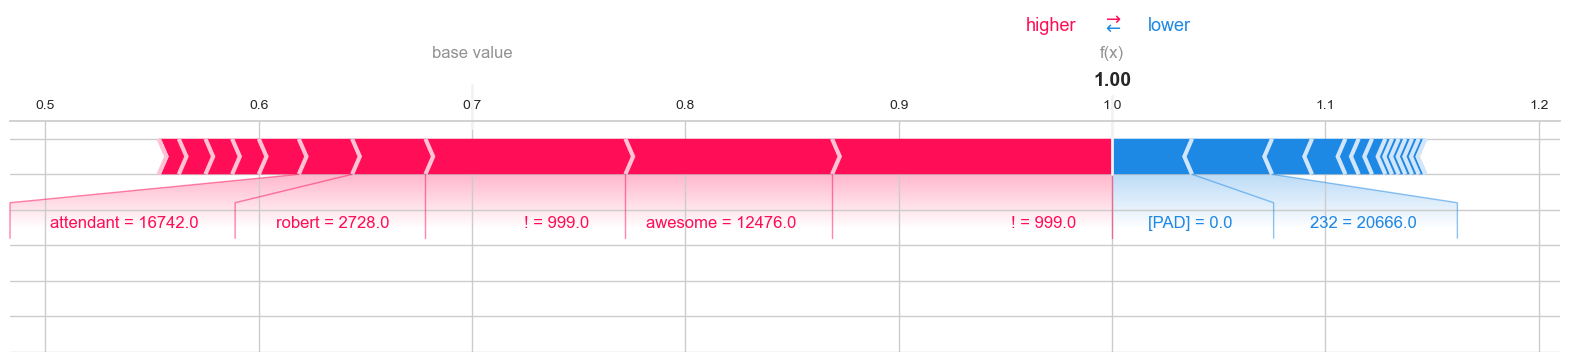

Sentence: direct message follow . luggage . ; Prediction: [1] ; True value: negative


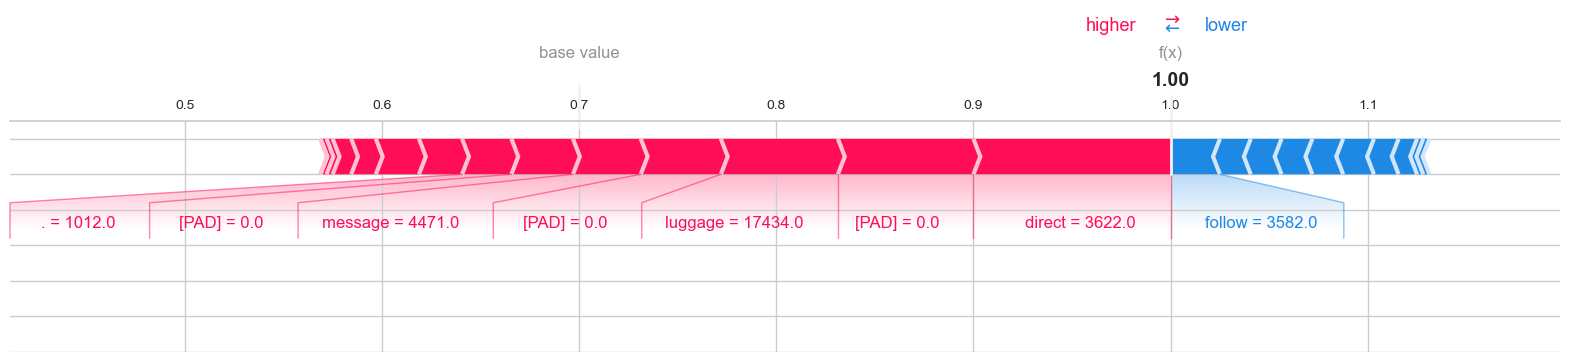

Sentence: ' m check 10 : 50 ##am ct flight t ##mm desktop website ' s working ( sort ca ##ching bug ) so ##s ; Prediction: [1] ; True value: negative


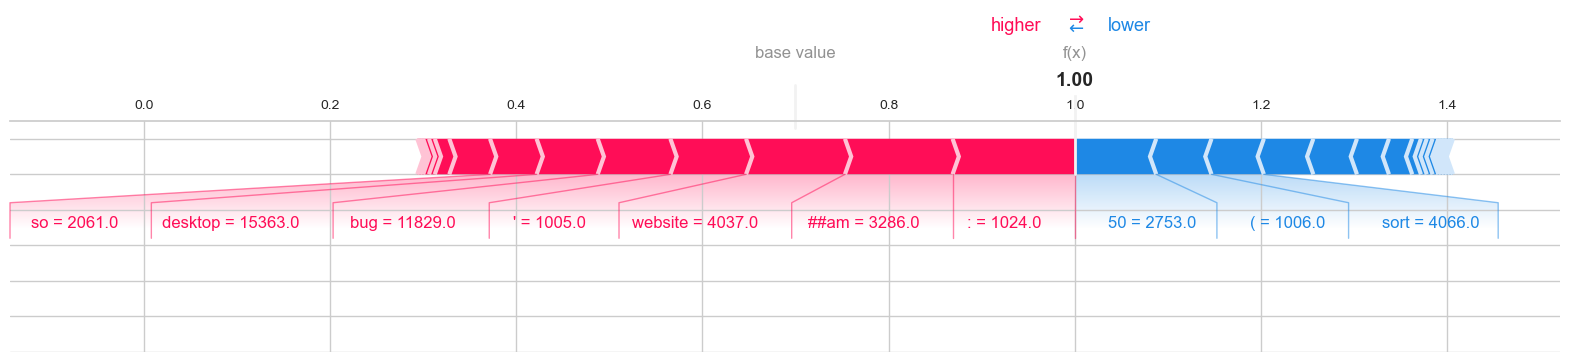

Sentence: funny story , website broken , missing java ##script styles ##hee ##ts check ##in process . dislike ! ; Prediction: [1] ; True value: negative


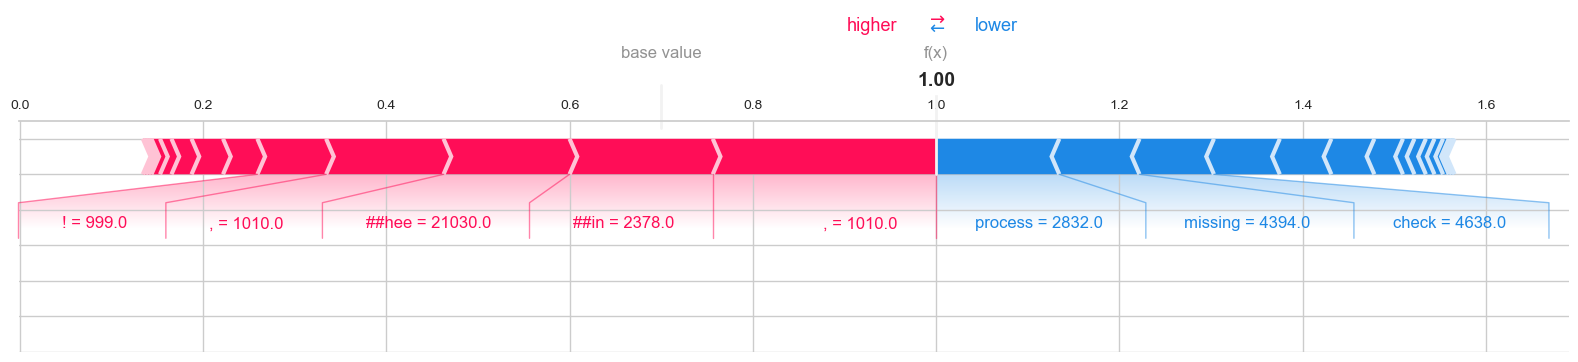

Sentence: time united flight delayed . big frustration . ; Prediction: [1] ; True value: negative


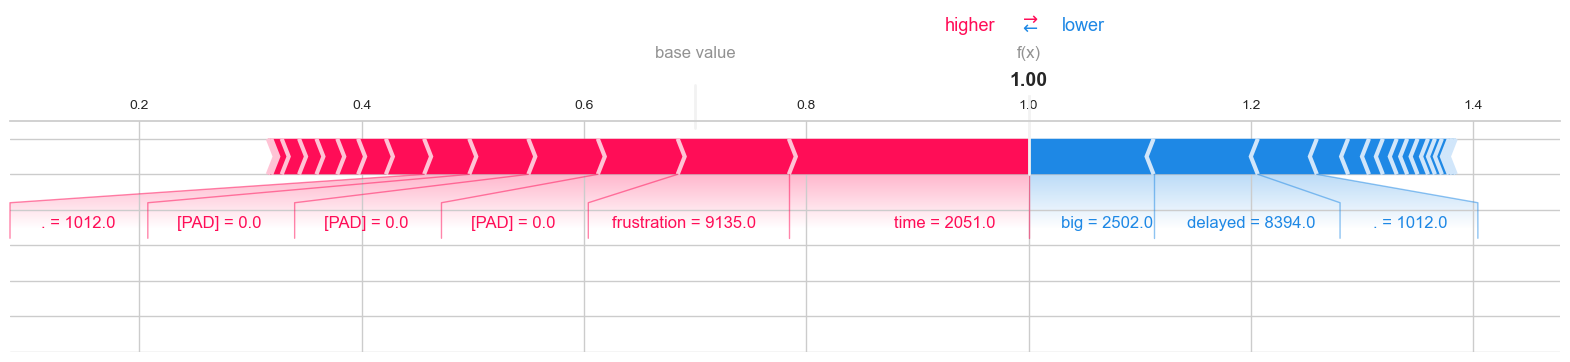

Sentence: , n ' t play video flights outfit ##ted w wi ##fi flights wi ##fi n ' t working . . . [UNK] ; Prediction: [1] ; True value: negative


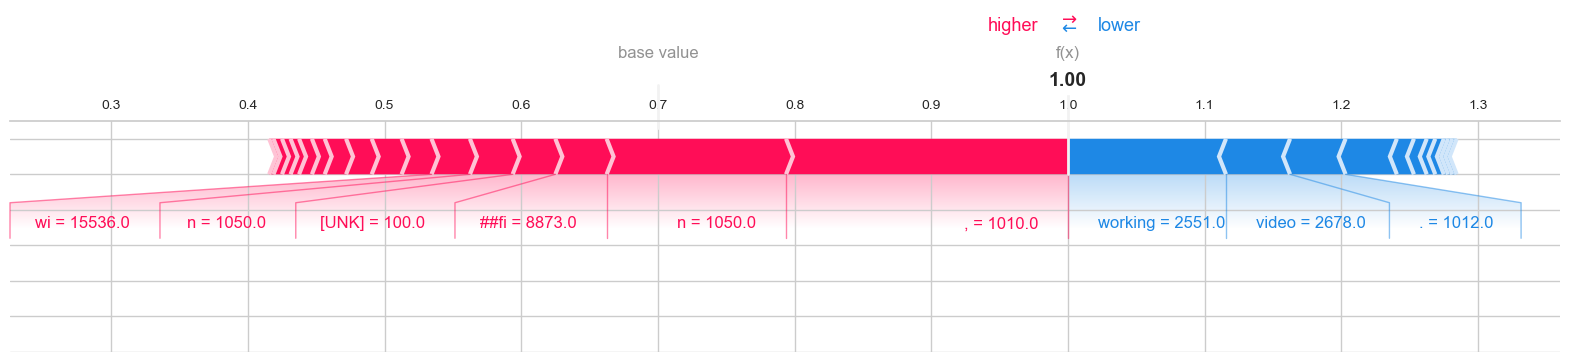

Sentence: res ##ched ##uled direct flight tonight 10 minutes - - hour earlier ! ; Prediction: [1] ; True value: positive


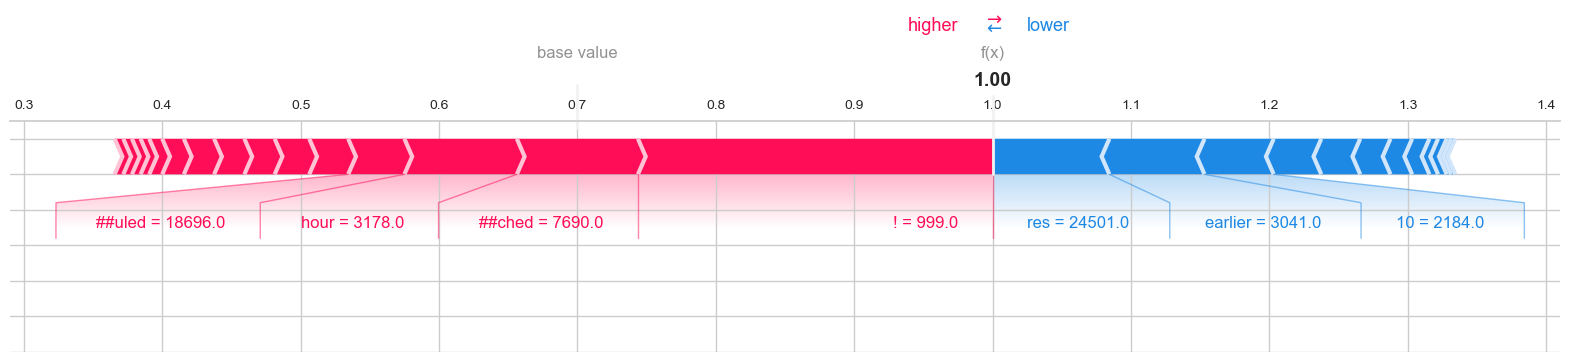

Sentence: great . deserved . ; Prediction: [1] ; True value: positive


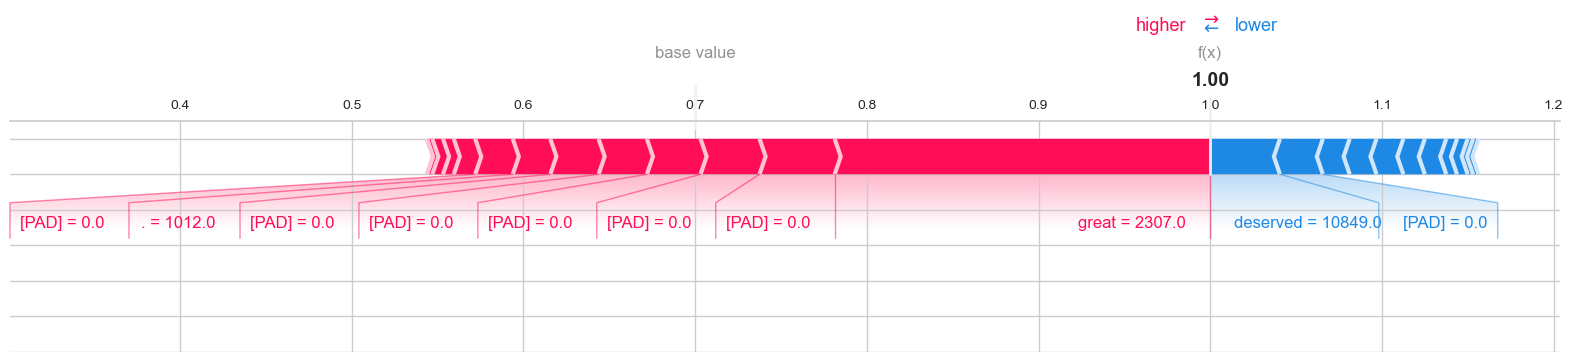

Sentence: ad ##ore , forward flight austin weeks . ; Prediction: [1] ; True value: positive


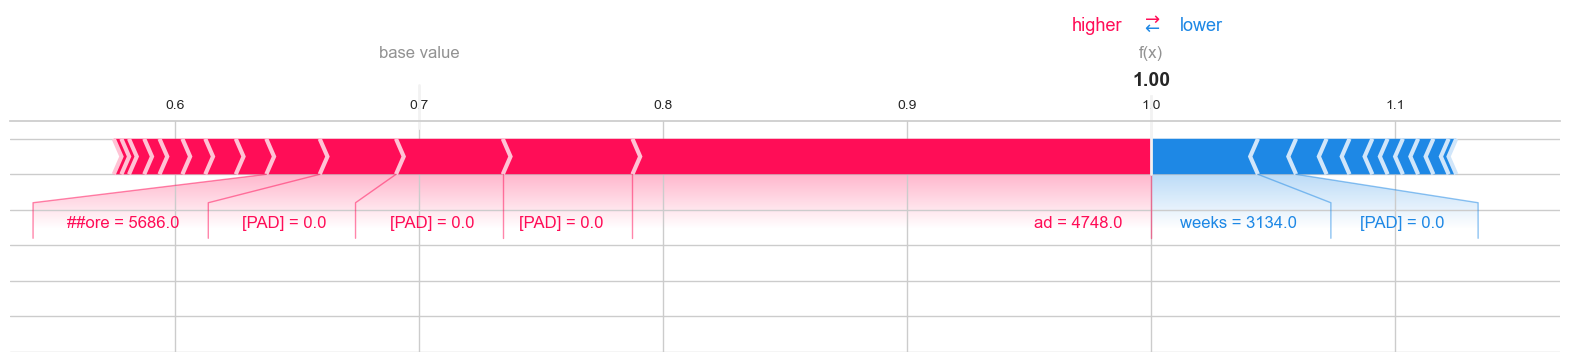

Sentence: long day delays . dallas tonight ! ! ! ! fingers crossed ! ! ! # winters ##torm ##20 ##15 # which ##is ##wo ##rse ##den ##ord ##f ##w . ; Prediction: [1] ; True value: negative


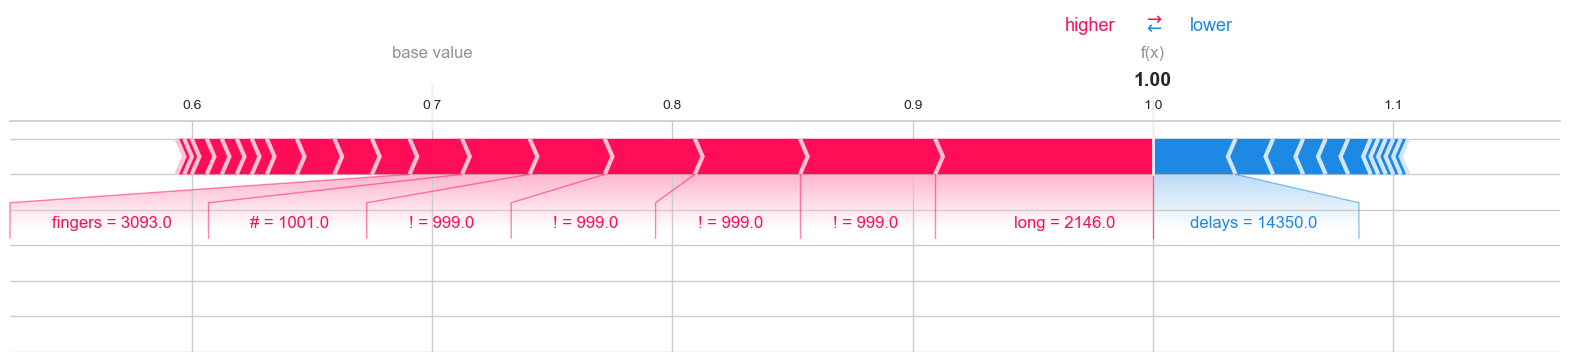

Sentence: agree ! : airline fly - away favorite # 9 ##ne ##ws ##bus ##iness ; Prediction: [1] ; True value: positive


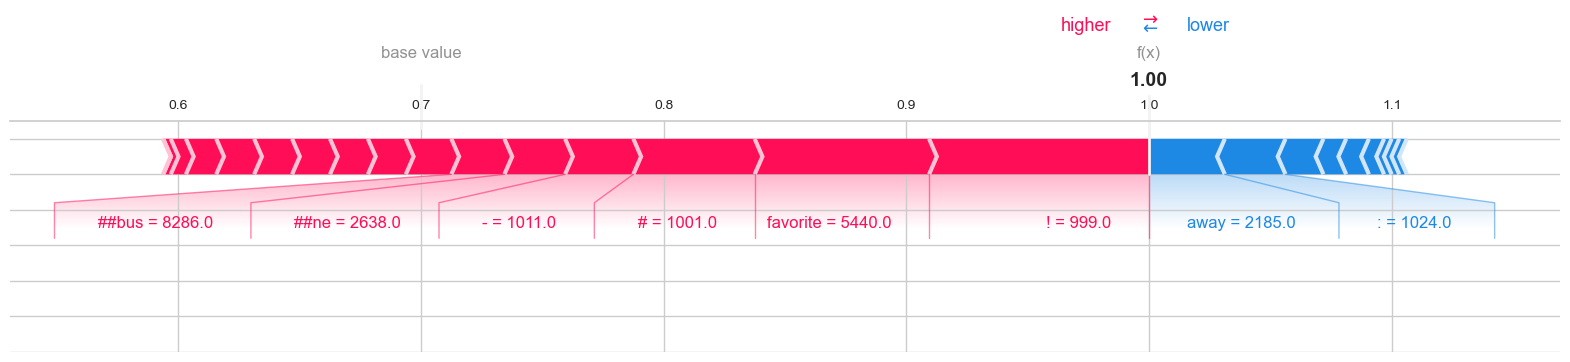

Sentence: , call fixed ? t ##wee ##ting bs questions stall makes things worse . phone number . ; Prediction: [1] ; True value: negative


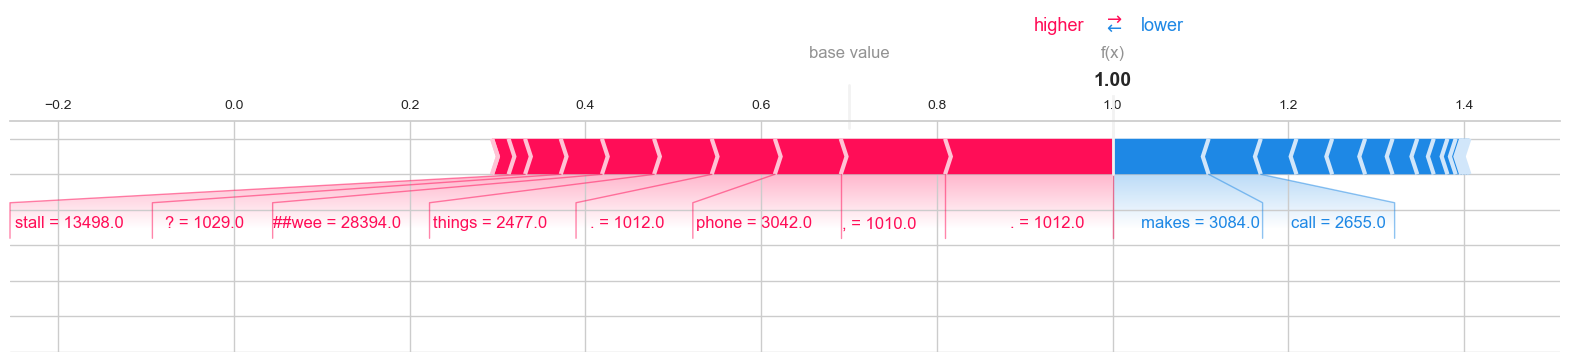

Sentence: sitting plane 3 : 15 un ##real . 2 + day nightmare ? ; Prediction: [0] ; True value: negative


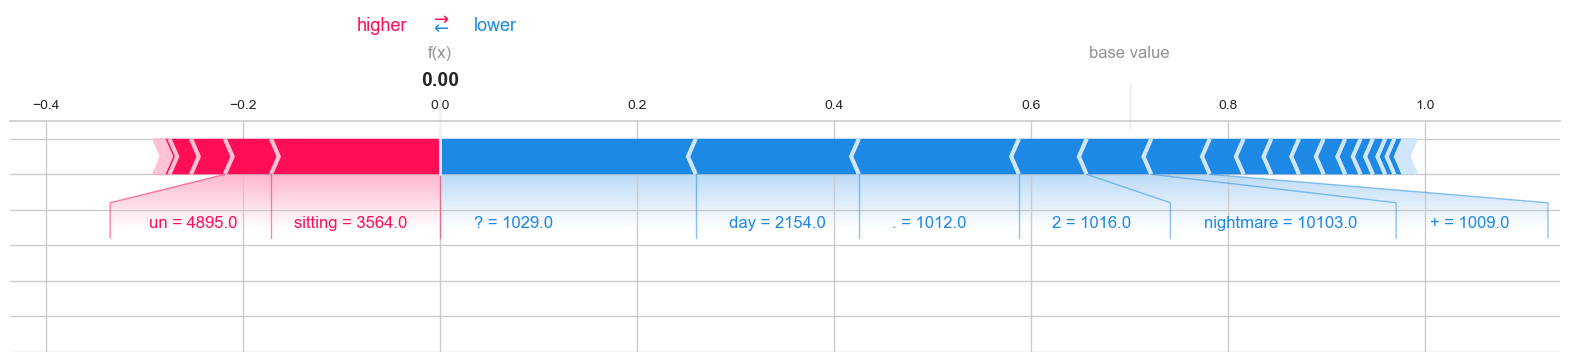

In [53]:
for i in range(len(to_explain)):
  print("Sentence:", " ".join(tokenizer.convert_ids_to_tokens(to_explain[i])).replace(" [PAD]", "") ,"; Prediction:", prediction_model(np.array([to_explain[i]])), "; True value:", y_test[i])
  shap.plots.force(perm_vals["base_values"][i], perm_vals["values"][i], perm_vals["data"][i], feature_names=tokenizer.convert_ids_to_tokens(perm_vals["data"][i]), matplotlib=True)

In [56]:
import copy
heatmaps = np.array(copy.copy(perm_vals["values"]))
heatmaps += perm_vals["base_values"][0]/64
for i in range(len(heatmaps)):
  print(np.sum(heatmaps[i]))

1.1102230246251565e-16
1.0
0.9999999999999998
1.3183898417423734e-16
0.0
-5.551115123125783e-17
8.326672684688674e-17
1.0
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999998
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
-5.551115123125783e-17


Prediction: negative


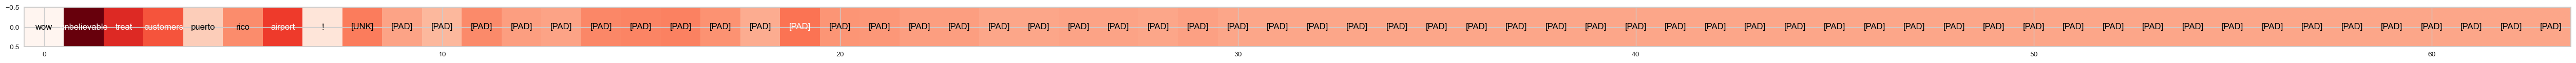

Prediction: positive


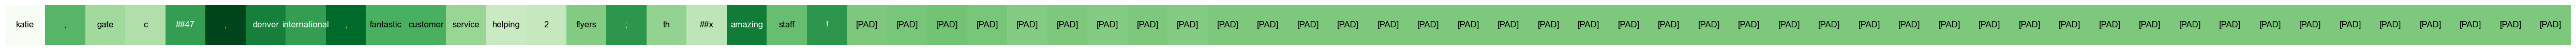

Prediction: positive


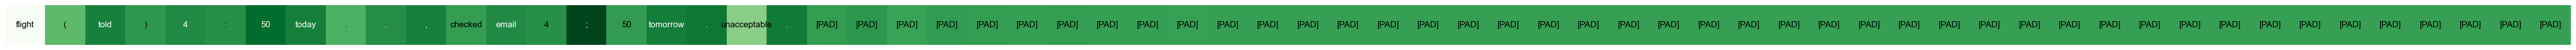

Prediction: negative


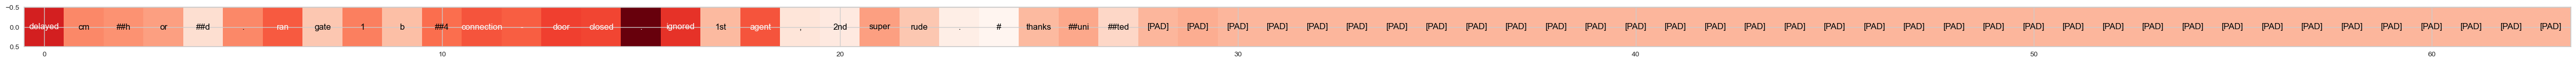

Prediction: negative


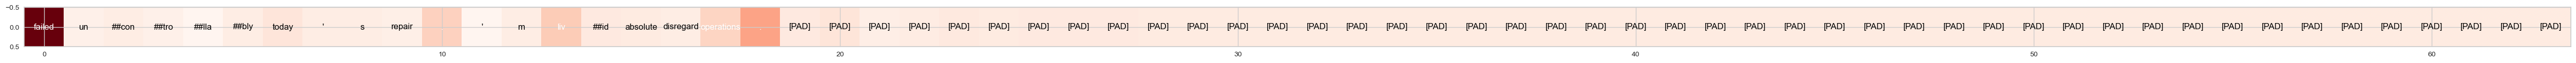

Prediction: negative


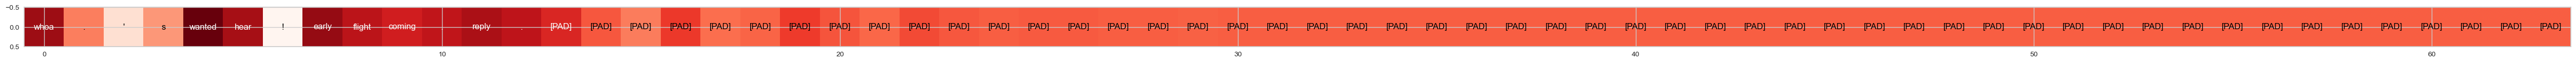

Prediction: negative


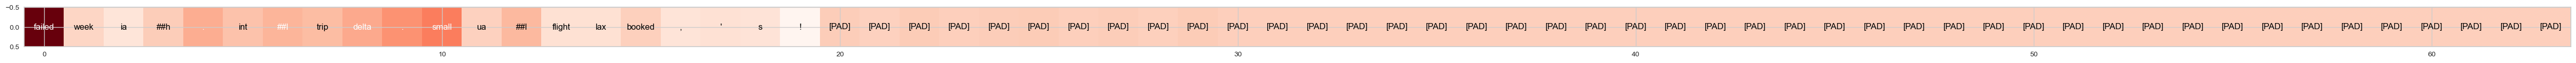

Prediction: positive


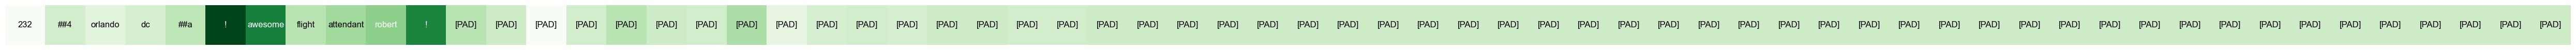

Prediction: positive


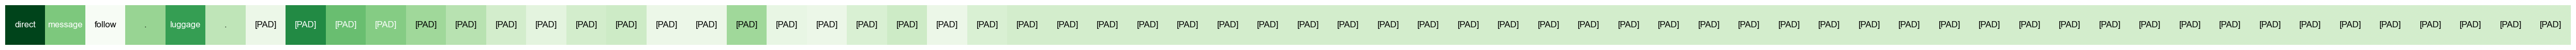

Prediction: positive


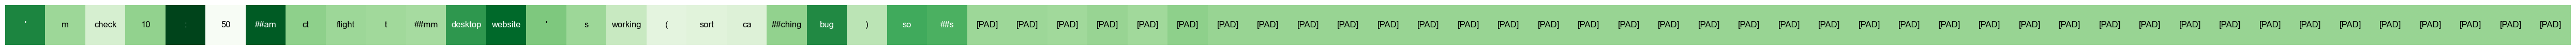

Prediction: positive


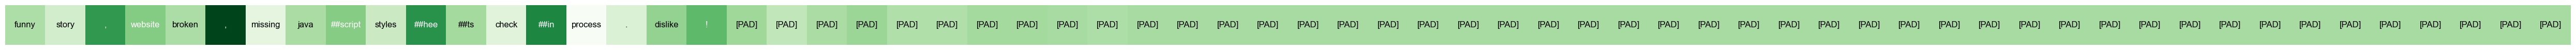

Prediction: positive


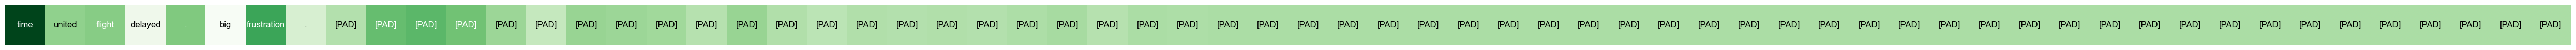

Prediction: positive


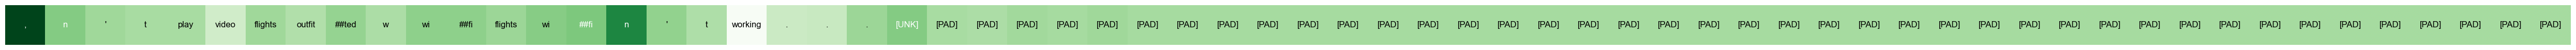

Prediction: positive


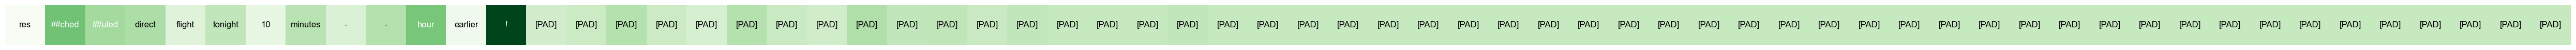

Prediction: positive


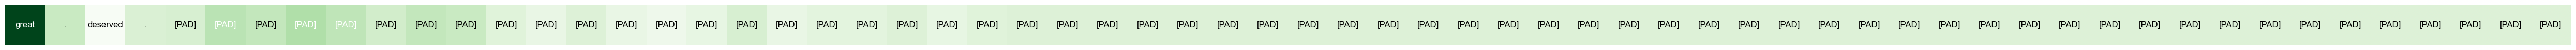

Prediction: positive


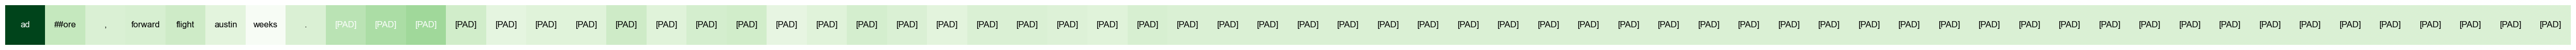

Prediction: positive


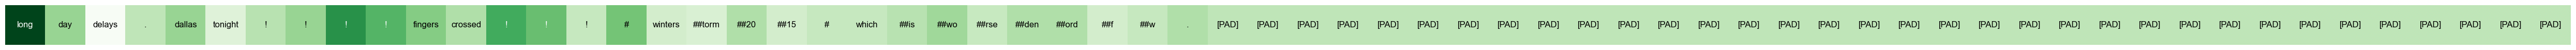

Prediction: positive


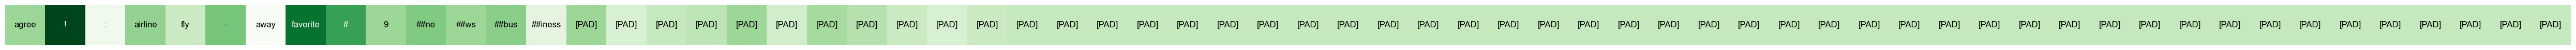

Prediction: positive


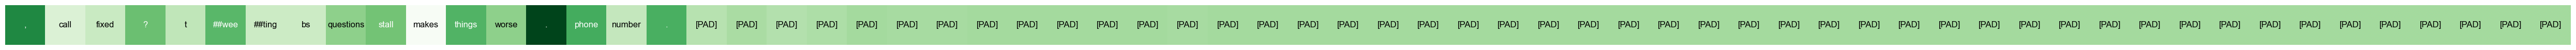

Prediction: negative


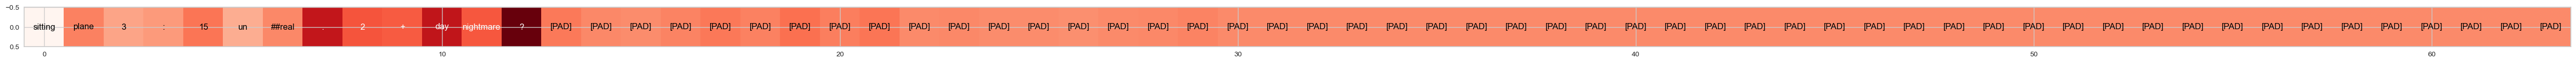

In [57]:
for x in range(len(to_explain)):
  fig, ax = plt.subplots(figsize=(len(to_explain[x]), 1))
  if prediction_model(np.array([to_explain[x]]))[0] == 0:
    print("Prediction: negative")
    ax.imshow([-heatmaps[x]], cmap="Reds", aspect="auto")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] < -0.04 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))
  else:
    print("Prediction: positive")
    ax.imshow([heatmaps[x]], cmap="Greens", aspect="auto")
    ax.axis("off")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] > 0.04 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))


  plt.show()

In [75]:
def ablate(x, i):
  x[i] = 0
  for j in range(i, len(x)-1):
    x[j] = x[j+1]
  x[-1] = 0
  return x
def compute_contrast(X, model, explanation):
  contrast = [0]*len(X)
  for i in range(len(X)):
    old_prediction = model(np.array([X[i]]))
    for j in range(len(X[i])):
      x = ablate(copy.deepcopy(X[i]), j)
      new_prediction = model(np.array([x]))
      if (new_prediction != old_prediction):
        contrast[i] += explanation[i][j]
  return contrast

In [86]:
def compute_distinctiveness(data, train_data, explanation):
  distinctiveness = [0] * len(data)

  frequencies = []
  for x in np.unique(train_data):
    frequencies.append((np.mean(np.array(train_data) == x), x))
  sorted_frequencies = sorted(frequencies)
  word_specialty = {0: 0}
  for i, (f, x) in enumerate(sorted_frequencies):
    word_specialty[x] = 1 - i / len(sorted_frequencies)

  for i in range(len(data)):
    for j in range(len(data[i])):
      try:
        distinctiveness[i] += word_specialty[data[i][j]] * explanation[i][j]
      except:
        distinctiveness[i] += explanation[i][j]

  return distinctiveness

In [87]:
def compute_fidelity(X, explanation, model):
    fidelity = [0] * len(X)
    samples = 10
    for i in range(len(X)):
        change_ratings = [0]*len(X[i])
        for x in range(len(X[i])):
            change_rating = 0
            for change in range(samples):
                new_X = copy.deepcopy(X[i])
                new_X[x] = new_X[x] + (2000 * change / samples)
                if (model(np.array([X[i]])) == model(np.array([new_X]))):
                    change_rating += 1/samples
            change_ratings[x] = change_rating
        for j in range(len(X[i])):
            fidelity[i] += change_ratings[j] * explanation[i][j]
    return fidelity

In [93]:
from nltk.corpus import wordnet as wn
def compute_realism(data, id_to_token, topic, explanation):
  """
  data: the word ids in the shape of #elements x #words
  topic: a wordnet synset
  id_to_token: a function from ids to tokens

  returns an array of length #elements
  """
  metrics = [0] * len(data)
  for i in range(len(data)):
    for j in range(len(data[i])):
      try:
        metrics[i] += explanation[i][j] * topic.wup_similarity(wn.synsets(id_to_token([data[i][j]])[0])[0])
      except:
        pass
  return metrics

In [137]:
for x in perm_vals["values"]:
  print(np.sum(x))

-0.5
-0.4999999999999999
-0.4999999999999997
-0.49999999999999994
-0.5000000000000001
-0.5000000000000002
-0.4999999999999996
-0.4999999999999999
-0.49999999999999994
-0.5000000000000001
-0.5000000000000003
-0.5000000000000001
-0.49999999999999994
-0.5
-0.49999999999999994
-0.5
-0.4999999999999999
-0.49999999999999994
-0.5000000000000001
-0.5


In [133]:
def explanation_converter(explanations):
  new_explanations = []
  for i in range(len(explanations)):
    if (explanations[i] > 0):
      new_explanations.append(explanations[i] + np.sum(1-explanations[i])/64)
    else:
      new_explanations.append(-explanations[i] + np.sum(1+explanations[i])/64)
  return new_explanations
standardized_explanations = explanation_converter(perm_vals["values"])

In [90]:
contrast = compute_contrast(to_explain, prediction_model, standardized_explanations)
print(contrast)

[-0.2875, 0.18124999999999997, 0.11249999999999996, 0, 0, -0.7156250000000001, -0.634375, 0, 0, 0.11562499999999998, 0.23437499999999997, 0.25625, 0.20625000000000002, 0.25625, 0, 0.21249999999999997, 0, 0, 0.19062500000000002, -0.259375]


In [91]:
distinctiveness = compute_distinctiveness(to_explain, X_train_padded, standardized_explanations)
print(distinctiveness)

[-0.2739431388438681, -0.06989633981631546, -0.009712655321447862, -0.27256381685575365, -0.47243550783360344, -0.40653869529983805, -0.565991356023771, -0.007958535926526157, 0.03661534305780657, 0.09139654240950847, 0.07088904646137224, 0.07754760940032414, -0.023900931928687152, -0.005907279848730411, -0.03865478119935172, 0.2248244192328471, 0.034589411129119396, 0.09459920313344135, 0.0715170853592653, -0.05770529443544028]


In [95]:
fidelity = compute_fidelity(to_explain, standardized_explanations, prediction_model)
print(fidelity)

[-0.36218749999999983, 0.25500000000000006, 0.07937500000000001, -0.6581249999999998, -0.47093749999999984, -0.2662499999999999, -0.28562499999999985, 0.30000000000000004, 0.28, 0.01906250000000008, -0.009999999999999905, 0.12656250000000005, 0.19374999999999998, 0.04593750000000005, 0.27812499999999996, 0.2340624999999999, 0.26375, 0.29843749999999997, 0.046250000000000055, -0.4009374999999999]


In [94]:
realism = compute_realism(to_explain, tokenizer.convert_ids_to_tokens, wn.synset("good.n.01"), standardized_explanations)
print(realism)

[-0.07095982142857142, -0.003206160669395947, -0.006599650349650366, -0.10567925181436211, -0.12049060008618835, -0.14530412296037298, -0.0997605580693816, 0.029083811409179063, 0.026487531565656565, -0.028353870394311552, -0.11073724682180563, 0.07416999666999666, 0.016067029375852908, -0.012454212454212446, 0.026267482517482506, 0.05514423076923076, 0.007015141721024079, 0.020764802631578948, -0.018197014382676135, -0.043972039473684194]


In [99]:
predictions = prediction_model(np.array(to_explain))
print(predictions)

[0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0]


In [2]:
import dill
filename = 'globalsave.pkl'
dill.dump_session(filename)

# and to load the session again:
#dill.load_session(filename)

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates